## Global PFT Allometries  

We load Tallo and BAAD and then cross reference by species to pull in PFT information from BAAD for the Tallo species. 
This way we  can use the extra data in Tallo but make use of the deciduous v evergreen designations from BAAD. 
nb BAAD is included in Tallo so combining  them does not make sense. 

For AGB we use Chave 2014 parameters for tropical trees and fit to extra tropical PFTs using BAAD data. 

This work is a collaboration with Adrianna Foster and Marcos Longo. 

#### Libraries

In [1]:
from scipy.stats import qmc
import numpy as np
import xarray as xr
import csv
import pandas as pd
import os
import netCDF4 as nc4
from scipy.io import netcdf as nc
import sys
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                     
import shutil                                                                                                                                                       
import tempfile 
import random

import math as m
from scipy.optimize import curve_fit
from scipy.stats import linregress

nan = float("nan")

#import functions_py.modp as mp
#import fates_xarray_functions as fa

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import cartopy.crs as ccrs
from matplotlib import cm

dark = cm.get_cmap('Paired', 12)
colormap = dark(range(12))

#### CSV files from the  Tallo github:

Main csv with dbh,  height, CA: https://github.com/selva-lab-repo/TALLO/tree/main/DB

Additional csv with biome info: https://github.com/selva-lab-repo/TALLO/tree/main/Jucker%20et%20al.%202022 - (Tallo_environment.csv)

In [2]:
df = pd.read_csv('/pscratch/sd/j/jneedham/trait_data/Tallo.csv')
df_env = pd.read_csv('/pscratch/sd/j/jneedham/trait_data/Tallo_environment.csv')


#### add biome column to main data frame

In [3]:
df_tallo = pd.merge(df, df_env, on='tree_id', how='outer')

### Make a PFT column that is so far just tropical/extra tropical and broad leaf evergreen

In [4]:
print(df_tallo['biome'].unique())

['Boreal/montane forest' 'Tropical rain forest'
 'Temperate broadleaf forest' 'Tropical savanna' 'Tropical dry forest'
 'Temperate grassland' 'Temperate conifer forest' 'Mediterranean woodland'
 'Dryland' 'Mangrove']


In [5]:
def condition(x) : 
    if x == 'Boreal/montane forest':
        return 'extratrop'
    elif x == 'Tropical rain forest': 
        return 'tropical'
    elif x == 'Temperate broadleaf forest': 
        return 'extratrop'
    elif x == 'Tropical savanna': 
        return 'tropical'
    elif x == 'Tropical dry forest': 
        return 'tropical'
    elif x == 'Temperate grassland': 
        return 'extratrop'
    elif x == 'Temperate conifer forest': 
        return 'extratrop'
    elif x == 'Mediterranean woodland': 
        return 'extratrop'
    elif x == 'Dryland': 
        return 'check'
    elif x == 'Mangrove': 
        return 'check'
    
df_tallo['pft1'] = df_tallo['biome'].apply(condition)

print(df_tallo['pft1'].unique())

['extratrop' 'tropical' 'check']


In [6]:
print(df_tallo['latitude'].min())
print(df_tallo['latitude'].max())

-51.56
69.88


In [7]:
# If biome isn't obvious use lat lon
def condition1b(x,y) : 
    if x == 'check' and abs(y) >=30 :
        return  'extratrop'
    elif x  == 'check' and abs(y) <30 :
        return 'tropical'
    else : 
        return  x
    
df_tallo['pft1'] = df_tallo.apply(lambda row: condition1b(row['pft1'],  row['latitude']), axis=1)


In [8]:
print(df_tallo['pft1'].unique())

['extratrop' 'tropical']


In [9]:
def condition2(x) : 
    if x == 'Angiosperm':
        return 'broadleaf'
    elif x == 'Gymnosperm': 
        return 'needleleaf'
   
    
df_tallo['pft2'] = df_tallo['division'].apply(condition2)

print(df_tallo['pft2'].unique())
print(df_tallo['division'].unique())

['broadleaf' 'needleleaf' None]
['Angiosperm' 'Gymnosperm' nan]


In [10]:
df_tallo['PFT_tallo'] = df_tallo['pft2'] + '_' + df_tallo['pft1']

In [11]:
# only keep relevant columns
keep = ['species', 'latitude', 'longitude', 'stem_diameter_cm', 'height_m', 'height_outlier', 'crown_radius_m', 
       'crown_radius_outlier', 'PFT_tallo']

df_tallo = df_tallo[keep]

# make a crown area column
df_tallo['crown_area']  = np.pi * df_tallo['crown_radius_m']**2 
# rename them 
new_col_names = {'stem_diameter_cm': 'dbh', 'height_m': 'height'}
df_tallo.rename(columns=new_col_names, inplace=True)

print(df_tallo.head(3))

            species  latitude  longitude   dbh  height height_outlier  \
0  Betula pubescens    67.395     28.723  10.0     5.6              N   
1       Picea abies    67.395     28.723  10.0     6.6              N   
2       Picea abies    67.395     28.723  10.0     8.5              N   

   crown_radius_m crown_radius_outlier             PFT_tallo  crown_area  
0            1.65                    N   broadleaf_extratrop    8.552986  
1            0.85                    N  needleleaf_extratrop    2.269801  
2            0.75                    N  needleleaf_extratrop    1.767146  


In [12]:
# Save the csv file 
df_tallo.to_csv('/pscratch/sd/j/jneedham/trait_data/Tallo_PFTs.csv', index=False)


### Plot them  - by PFT

In [13]:
lon_bl_ex  = df_tallo.loc[df_tallo['PFT_tallo'] == 'broadleaf_extratrop','longitude']
lat_bl_ex  = df_tallo.loc[df_tallo['PFT_tallo'] == 'broadleaf_extratrop','latitude']

lon_nl_ex  = df_tallo.loc[df_tallo['PFT_tallo'] == 'needleleaf_extratrop','longitude']
lat_nl_ex  = df_tallo.loc[df_tallo['PFT_tallo'] == 'needleleaf_extratrop','latitude']

lon_bl_tr  = df_tallo.loc[df_tallo['PFT_tallo'] == 'broadleaf_tropical','longitude']
lat_bl_tr  = df_tallo.loc[df_tallo['PFT_tallo'] == 'broadleaf_tropical','latitude']

lon_nl_tr  = df_tallo.loc[df_tallo['PFT_tallo'] == 'broadleaf_tropical','longitude']
lat_nl_tr  = df_tallo.loc[df_tallo['PFT_tallo'] == 'broadleaf_tropical','latitude']


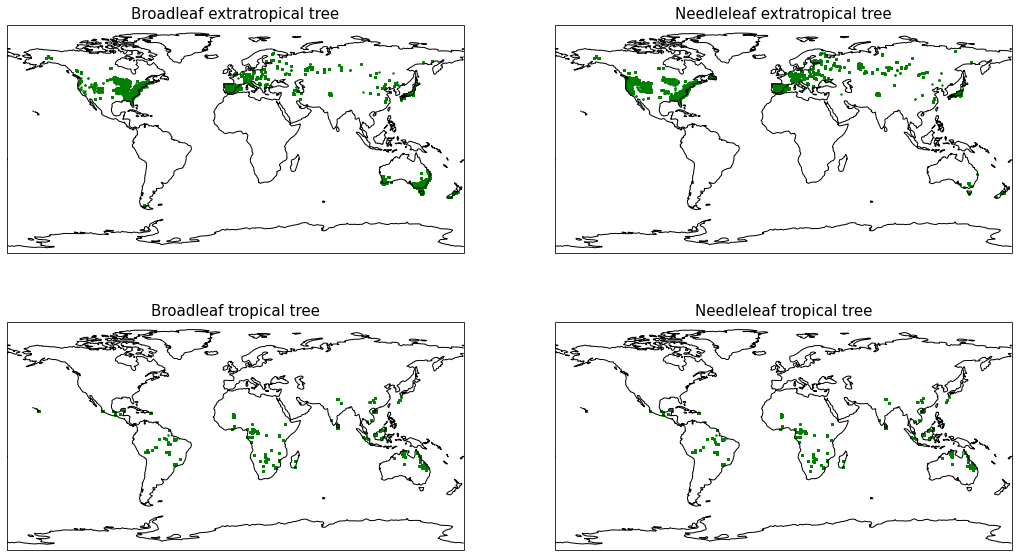

In [14]:
fig1, ((f1ax0,f1ax1),(f1ax2,f1ax3)) = plt.subplots(nrows=2,  ncols=2,
                                                   subplot_kw={'projection': ccrs.PlateCarree()},
                                                   figsize=(18,10))
# Extra tropical broadleaf
f1ax0.scatter(lon_bl_ex, lat_bl_ex, color='green', s=2, marker='o', transform=ccrs.PlateCarree())
f1ax0.coastlines()
f1ax0.set_title('Broadleaf extratropical tree', fontsize=15)

# Extra tropical needleleaf
f1ax1.scatter(lon_nl_ex, lat_nl_ex, color='green', s=2, marker='o', transform=ccrs.PlateCarree())
f1ax1.coastlines()
f1ax1.set_title('Needleleaf extratropical tree', fontsize=15)

# tropical broadleaf
f1ax2.scatter(lon_bl_tr, lat_bl_tr, color='green', s=2, marker='o', transform=ccrs.PlateCarree())
f1ax2.coastlines()
f1ax2.set_title('Broadleaf tropical tree', fontsize=15)

# tropical needleleaf
f1ax3.scatter(lon_nl_tr, lat_nl_tr, color='green', s=2, marker='o', transform=ccrs.PlateCarree())
f1ax3.coastlines()
f1ax3.set_title('Needleleaf tropical tree', fontsize=15)

f1ax0.set_global()
f1ax1.set_global()
f1ax2.set_global()
f1ax3.set_global()

## Load BAAD data and make a PFT column

Analysis adapted from Adrianna Foster

In [15]:
df_baad = pd.read_csv('/pscratch/sd/j/jneedham/trait_data/baad_data_utf8.csv', encoding='utf-8')

In [16]:
def condition(x) : 
    if x == 'EA':
        return 'broadleaf_evergreen'
    elif x == 'EG': 
        return 'needleleaf_evergreen'
    elif x == 'DA': 
        return 'broadleaf_deciduous'
    elif x == 'DG': 
        return 'needleleaf_deciduous'
    
    
df_baad['pft_fates1'] = df_baad['pft'].apply(condition)

In [17]:
def condition(x) : 
    if x == 'Borf':
        return 'extratrop'
    elif x == 'TropRF': 
        return 'tropical'
    elif x == 'TempF': 
        return 'extratrop'
    elif x == 'Sh': 
        return 'check'
    elif x == 'TropSF': 
        return 'tropical'
    elif x == 'Wo': 
        return 'check'
    elif x == 'TempRF': 
        return 'extratrop'
    elif x == 'Sav': 
        return 'check'
    elif x == 'Gr': 
        return 'check'
    
df_baad['pft_fates2'] = df_baad['vegetation'].apply(condition)

In [18]:
def condition1b(x,y) : 
    if x == 'check' and abs(y) >=30 :
        return  'extratrop'
    elif x  == 'check' and abs(y) <30 :
        return 'tropical'
    else : 
        return  x
    
df_baad['pft_fates2'] = df_baad.apply(lambda row: condition1b(row['pft_fates2'],  row['latitude']), axis=1)

In [19]:
# remove green house
allowed_growth = ['FW', 'FE', 'PU', 'PM']
mask = df_baad['growingCondition'].isin(allowed_growth)
df_baad = df_baad[mask]

In [20]:
df_baad['PFT_baad'] = df_baad['pft_fates1'] + '_' + df_baad['pft_fates2']

In [21]:
# remove nans in PFT
df_baad = df_baad.dropna(subset=['PFT_baad'])
print(df_baad['PFT_baad'].unique())

['broadleaf_evergreen_tropical' 'needleleaf_evergreen_extratrop'
 'broadleaf_evergreen_extratrop' 'broadleaf_deciduous_extratrop'
 'needleleaf_deciduous_extratrop' 'broadleaf_deciduous_tropical']


In [22]:
# Select relevant columns
keep = ['PFT_baad', 'family',  'speciesMatched', 'latitude', 'longitude', 'd.bh', 'h.t', 'a.cp', 'm.so', 'r.st']
df_baad = df_baad[keep]

# rename columns 
new_col_names = {'speciesMatched': 'species', 'd.bh': 'dbh', 'h.t': 'height', 'a.cp': 'crown_area',  'm.so': 'agb', 'r.st': 'wd'}
df_baad.rename(columns=new_col_names, inplace=True)

print(df_baad.head(3))

                        PFT_baad            family       species  latitude  \
17  broadleaf_evergreen_tropical  Dipterocarpaceae  Shorea acuta      4.03   
18  broadleaf_evergreen_tropical  Dipterocarpaceae  Shorea acuta      4.03   
19  broadleaf_evergreen_tropical  Dipterocarpaceae  Shorea acuta      4.03   

    longitude  dbh  height  crown_area      agb  wd  
17     113.83  NaN    0.15      0.0449  0.00274 NaN  
18     113.83  NaN    0.39      0.0570  0.00441 NaN  
19     113.83  NaN    0.43      0.0471  0.00277 NaN  


In [23]:
# keep only plants  with dbh
df_baad = df_baad.dropna(subset=['dbh'])
# convert dbh  to cm 
df_baad['dbh'] = df_baad['dbh'] * 100.0
#print(df_baad.head(3))

In [24]:
print(df_baad.groupby(['PFT_baad']).count())

lon_bldex  = df_baad.loc[df_baad['PFT_baad'] == 'broadleaf_deciduous_extratrop','longitude']
lat_bldex  = df_baad.loc[df_baad['PFT_baad'] == 'broadleaf_deciduous_extratrop','latitude']

lon_bleex  = df_baad.loc[df_baad['PFT_baad'] == 'broadleaf_evergreen_extratrop','longitude']
lat_bleex  = df_baad.loc[df_baad['PFT_baad'] == 'broadleaf_evergreen_extratrop','latitude']

lon_nldex  = df_baad.loc[df_baad['PFT_baad'] == 'needleleaf_deciduous_extratrop','longitude']
lat_nldex  = df_baad.loc[df_baad['PFT_baad'] == 'needleleaf_deciduous_extratrop','latitude']

lon_nleex  = df_baad.loc[df_baad['PFT_baad'] == 'needleleaf_evergreen_extratrop','longitude']
lat_nleex  = df_baad.loc[df_baad['PFT_baad'] == 'needleleaf_evergreen_extratrop','latitude']

lon_bldtr  = df_baad.loc[df_baad['PFT_baad'] == 'broadleaf_deciduous_tropical','longitude']
lat_bldtr  = df_baad.loc[df_baad['PFT_baad'] == 'broadleaf_deciduous_tropical','latitude']

lon_bletr  = df_baad.loc[df_baad['PFT_baad'] == 'broadleaf_evergreen_tropical','longitude']
lat_bletr  = df_baad.loc[df_baad['PFT_baad'] == 'broadleaf_evergreen_tropical','latitude']


                                family  species  latitude  longitude   dbh  \
PFT_baad                                                                     
broadleaf_deciduous_extratrop     1261     1270      1216       1216  1270   
broadleaf_deciduous_tropical       149      185       185        185   185   
broadleaf_evergreen_extratrop     1238     1270      1270       1270  1270   
broadleaf_evergreen_tropical      2661     2713      2713       2713  2713   
needleleaf_deciduous_extratrop      78       83        83         83    83   
needleleaf_evergreen_extratrop    1744     1805      1796       1796  1805   

                                height  crown_area   agb   wd  
PFT_baad                                                       
broadleaf_deciduous_extratrop     1240         275  1168   86  
broadleaf_deciduous_tropical       185          21   176  107  
broadleaf_evergreen_extratrop     1225          77  1175    0  
broadleaf_evergreen_tropical      2670        1409  153

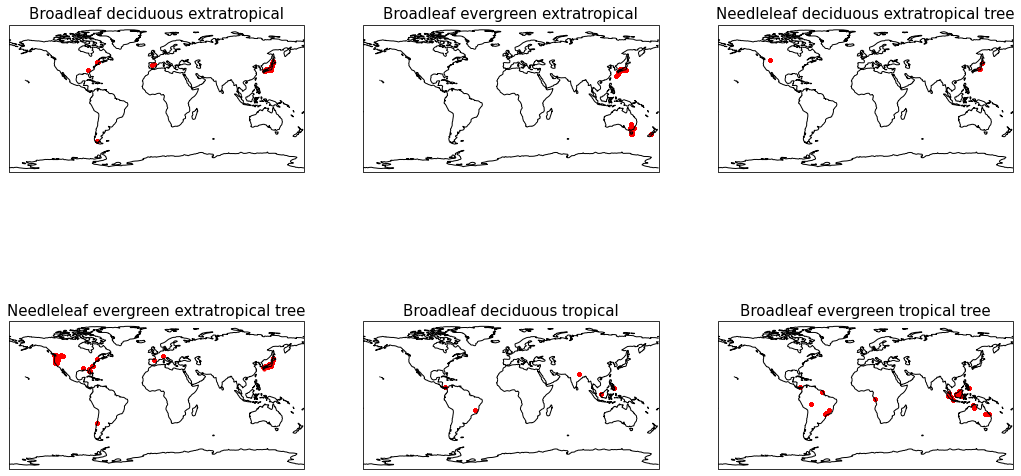

In [25]:
fig1, ((f1ax0,f1ax1,f1ax2),(f1ax3,f1ax4,f1ax5)) = plt.subplots(nrows=2,  ncols=3,
                                                   subplot_kw={'projection': ccrs.PlateCarree()},
                                                   figsize=(18,10))
# Extra tropical deciduos broadleaf
f1ax0.scatter(lon_bldex, lat_bldex, color='red', s=10, marker='o', transform=ccrs.PlateCarree())
f1ax0.coastlines()
f1ax0.set_title('Broadleaf deciduous extratropical', fontsize=15)

# Extra tropical evergreen broadleaf
f1ax1.scatter(lon_bleex, lat_bleex, color='red', s=10, marker='o', transform=ccrs.PlateCarree())
f1ax1.coastlines()
f1ax1.set_title('Broadleaf evergreen extratropical', fontsize=15)

# Extra tropical deciduous needleleaf
f1ax2.scatter(lon_nldex, lat_nldex, color='red', s=10, marker='o', transform=ccrs.PlateCarree())
f1ax2.coastlines()
f1ax2.set_title('Needleleaf deciduous extratropical tree', fontsize=15)

# Extra tropical evergreen needleleaf
f1ax3.scatter(lon_nleex, lat_nleex, color='red', s=10, marker='o', transform=ccrs.PlateCarree())
f1ax3.coastlines()
f1ax3.set_title('Needleleaf evergreen extratropical tree', fontsize=15)

# tropical deciduous broadleaf
f1ax4.scatter(lon_bldtr, lat_bldtr, color='red', s=10, marker='o', transform=ccrs.PlateCarree())
f1ax4.coastlines()
f1ax4.set_title('Broadleaf deciduous tropical', fontsize=15)

# tropical evergreen broadleaf 
f1ax5.scatter(lon_bletr, lat_bletr, color='red', s=10, marker='o', transform=ccrs.PlateCarree())
f1ax5.coastlines()
f1ax5.set_title('Broadleaf evergreen tropical tree', fontsize=15)

f1ax0.set_global()
f1ax1.set_global()
f1ax2.set_global()
f1ax3.set_global()
f1ax4.set_global()
f1ax5.set_global()



### Use  PFT info from BAAD for Tallo data 

In [26]:
# make a table of unique species and pfts from BAAD
baad_pfts = df_baad[['species', 'PFT_baad']]
baad_pfts = baad_pfts.drop_duplicates()
baad_pfts.head(3)

,species,PFT_baad
775,Pinus densiflora,needleleaf_evergreen_extratrop
845,Acacia mearnsii,broadleaf_evergreen_extratrop
861,Acacia dealbata,broadleaf_evergreen_extratrop


In [27]:
merged_df = df_tallo.merge(baad_pfts, left_on='species', right_on='species', how='left')
merged_df['PFT_tallo'] = merged_df['PFT_baad'].fillna(merged_df['PFT_tallo'])
merged_df = merged_df.drop(columns=['PFT_baad'])
print(merged_df.head(3))

            species  latitude  longitude   dbh  height height_outlier  \
0  Betula pubescens    67.395     28.723  10.0     5.6              N   
1       Picea abies    67.395     28.723  10.0     6.6              N   
2       Picea abies    67.395     28.723  10.0     8.5              N   

   crown_radius_m crown_radius_outlier                       PFT_tallo  \
0            1.65                    N             broadleaf_extratrop   
1            0.85                    N  needleleaf_evergreen_extratrop   
2            0.75                    N  needleleaf_evergreen_extratrop   

   crown_area  
0    8.552986  
1    2.269801  
2    1.767146  


In [28]:
print(merged_df['PFT_tallo'].unique())

['broadleaf_extratrop' 'needleleaf_evergreen_extratrop'
 'broadleaf_evergreen_extratrop' 'broadleaf_tropical'
 'broadleaf_evergreen_tropical' 'needleleaf_tropical'
 'broadleaf_deciduous_extratrop' 'broadleaf_deciduous_tropical' nan
 'needleleaf_extratrop' 'needleleaf_deciduous_extratrop']


In [29]:
# replace all broadleaf deciduous/evergreen with just broadleaf tropical 
def condition(x) : 
    if x == 'broadleaf_evergreen_tropical':
        return 'broadleaf_tropical'
    elif x == 'broadleaf_deciduous_tropical': 
        return 'broadleaf_tropical'
    else : 
        return x
    
merged_df['PFT_tallo'] = merged_df['PFT_tallo'].apply(condition)

print(merged_df.groupby('PFT_tallo')['species'].count())

PFT_tallo
broadleaf_deciduous_extratrop      33829
broadleaf_evergreen_extratrop       8275
broadleaf_extratrop               118968
broadleaf_tropical                174223
needleleaf_deciduous_extratrop       224
needleleaf_evergreen_extratrop     38192
needleleaf_extratrop               62645
needleleaf_tropical                 1921
Name: species, dtype: int64


## Use Tallo now

In [30]:
df_tallo = merged_df

### Martinez-cano height allometry

In [31]:
def d2hmc (d, p1, p2, p3) :
    h = (p1 * d**p2) / (p3 + d**p2)
    return h

initial_guess = [58.0, 0.73, 21.8]


#### Broadleaf tropical

[78.40877039  0.81243829 47.66661644]


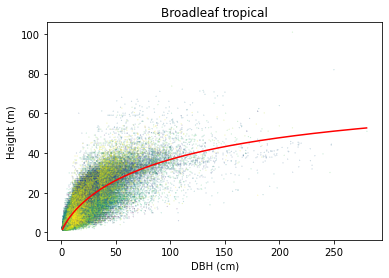

In [32]:
# Broadleaf tropical
bltr = df_tallo[df_tallo.PFT_tallo=='broadleaf_tropical']
bltr =  bltr.dropna(subset=['height', 'dbh'])
# remove outliers
bltr = bltr[bltr['height_outlier'] == 'N']

height_ps_bltr, height_cov_bltr = curve_fit(f=d2hmc, xdata=np.array(bltr['dbh']), ydata=np.array(bltr['height']),
                                           p0=initial_guess)

dbh_bltr = np.arange(1,bltr['dbh'].max(),1)

bltr_curve = [d2hmc(d, height_ps_bltr[0], height_ps_bltr[1], height_ps_bltr[2])  for  d  in dbh_bltr]

plt.scatter(bltr.dbh, bltr.height, s=0.01, c=pd.factorize(bltr['species'])[0])
plt.plot(dbh_bltr, bltr_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('Height (m)')
plt.title('Broadleaf tropical')

print(height_ps_bltr)

#### Needleleaf evergreen extra tropical  

[306.84266695   0.75237703 196.68656908]


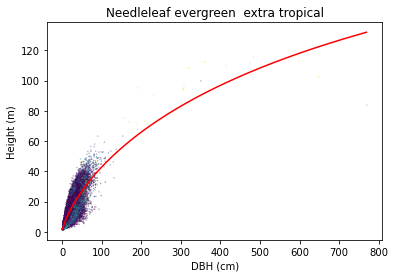

In [33]:
# Needleleaf evergreen extra tropical 
nleex = df_tallo[df_tallo.PFT_tallo=='needleleaf_evergreen_extratrop']
nleex =  nleex.dropna(subset=['height', 'dbh'])
# remove outliers
nleex = nleex[nleex['height_outlier'] == 'N']

height_ps_nleex, height_cov_nleex = curve_fit(f=d2hmc, xdata=np.array(nleex['dbh']), ydata=np.array(nleex['height']),
                                           p0=initial_guess)

dbh_nleex = np.arange(1,nleex['dbh'].max(),1)

nleex_curve = [d2hmc(d, height_ps_nleex[0], height_ps_nleex[1], height_ps_nleex[2])  for  d  in dbh_nleex]

plt.scatter(nleex.dbh, nleex.height, s=0.05, c=pd.factorize(nleex['species'])[0])
plt.plot(dbh_nleex, nleex_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('Height (m)')
plt.title('Needleleaf evergreen  extra tropical')

print(height_ps_nleex)

#### Needleleaf deciduous extra tropical 

[106.87458211   0.94713018  93.97904614]


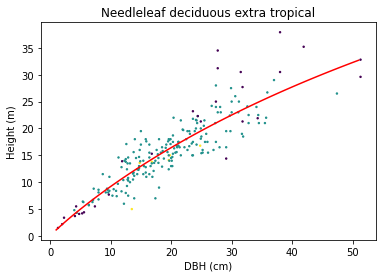

In [34]:
# Needleleaf deciduous extra tropical 
nldex = df_tallo[df_tallo.PFT_tallo=='needleleaf_deciduous_extratrop']
nldex =  nldex.dropna(subset=['height', 'dbh'])
# remove outliers
nldex = nldex[nldex['height_outlier'] == 'N']

height_ps_nldex, height_cov_nldex = curve_fit(f=d2hmc, xdata=np.array(nldex['dbh']), ydata=np.array(nldex['height']),
                                           p0=initial_guess)

dbh_nldex = np.arange(1,nldex['dbh'].max(),1)

nldex_curve = [d2hmc(d, height_ps_nldex[0], height_ps_nldex[1], height_ps_nldex[2])  for  d  in dbh_nldex]

plt.scatter(nldex.dbh, nldex.height, s=2, c=pd.factorize(nldex['species'])[0])
plt.plot(dbh_nldex, nldex_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('Height (m)')
plt.title('Needleleaf deciduous extra tropical')

print(height_ps_nldex)

#### Broadleaf evergreen extra tropical  

[104.3586841    1.11469727 160.68350891]


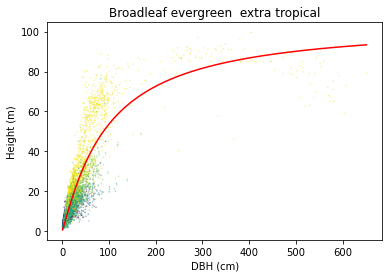

In [35]:
# Broadleaf evergreen extra tropical 
bleex = df_tallo[df_tallo.PFT_tallo=='broadleaf_evergreen_extratrop']
bleex =  bleex.dropna(subset=['height', 'dbh'])
# remove outliers
bleex = bleex[bleex['height_outlier'] == 'N']

height_ps_bleex, height_cov_bleex = curve_fit(f=d2hmc, xdata=np.array(bleex['dbh']), ydata=np.array(bleex['height']),
                                           p0=initial_guess)

dbh_bleex = np.arange(1,bleex['dbh'].max(),1)

bleex_curve = [d2hmc(d, height_ps_bleex[0], height_ps_bleex[1], height_ps_bleex[2])  for  d  in dbh_bleex]

plt.scatter(bleex.dbh, bleex.height, s=0.05, c=pd.factorize(bleex['species'])[0])
plt.plot(dbh_bleex, bleex_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('Height (m)')
plt.title('Broadleaf evergreen  extra tropical')

print(height_ps_bleex)

Text(0.5, 1.0, 'Broadleaf evergreen  extra tropical')

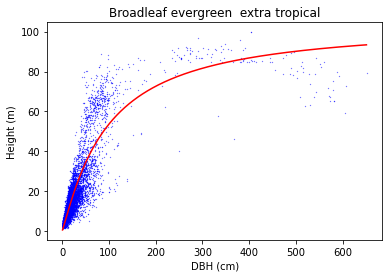

In [36]:
plt.scatter(bleex.dbh, bleex.height, s=0.05, color='blue')
plt.plot(dbh_bleex, bleex_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('Height (m)')
plt.title('Broadleaf evergreen  extra tropical')


#### Broadleaf deciduous extra tropical 

[29.69929379  1.12959569 25.12579143]


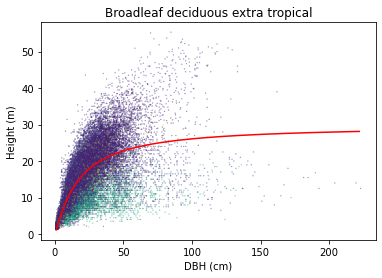

In [37]:
# Broadleaf deciduous extra tropical 
bldex = df_tallo[df_tallo.PFT_tallo=='broadleaf_deciduous_extratrop']
bldex =  bldex.dropna(subset=['height', 'dbh'])
# remove outliers
bldex = bldex[bldex['height_outlier'] == 'N']

height_ps_bldex, height_cov_bldex = curve_fit(f=d2hmc, xdata=np.array(bldex['dbh']), ydata=np.array(bldex['height']),
                                           p0=initial_guess)

dbh_bldex = np.arange(1,bldex['dbh'].max(),1)

bldex_curve = [d2hmc(d, height_ps_bldex[0], height_ps_bldex[1], height_ps_bldex[2])  for  d  in dbh_bldex]

plt.scatter(bldex.dbh, bldex.height, s=0.05, c=pd.factorize(bldex['species'])[0])
plt.plot(dbh_bldex, bldex_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('Height (m)')
plt.title('Broadleaf deciduous extra tropical')

print(height_ps_bldex)

What is going on with those tall and short trees? is that a regional thing? Or understory v canopy specialists?

Oaks are the problem!!!

In [38]:
value_counts = bldex['species'].value_counts()
print(value_counts)

Fagus sylvatica       8931
Acer saccharum        5743
Quercus pyrenaica     4129
Acer rubrum           3540
Fagus grandifolia     1749
                      ... 
Aesculus turbinata       1
Alnus pendula            1
Mallotus japonicus       1
Magnolia kobus           1
Acer japonicum           1
Name: species, Length: 84, dtype: int64


Text(0.5, 0.01, 'DBH (cm)')

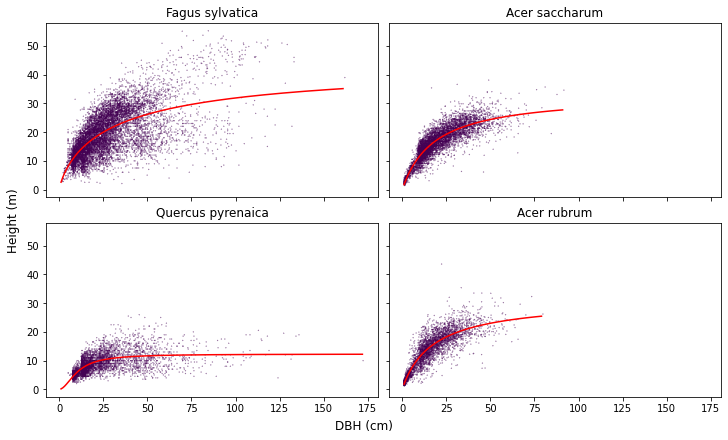

In [39]:
fig, axs = plt.subplots(nrows=2,ncols=2,
                        figsize=(10,6), sharex=True,  sharey=True, constrained_layout=True)

axs=axs.flatten()

species = ['Fagus sylvatica', 'Acer saccharum',  'Quercus pyrenaica', 'Acer rubrum']

for i  in range(0,len(species))  :
    
    bldex = df_tallo[df_tallo.species==species[i]]
    bldex =  bldex.dropna(subset=['height', 'dbh'])
    # remove outliers
    bldex = bldex[bldex['height_outlier'] == 'N']

    height_ps_bldex, height_cov_bldex = curve_fit(f=d2hmc, xdata=np.array(bldex['dbh']), ydata=np.array(bldex['height']),
                                               p0=initial_guess)
    
    dbh_bldex = np.arange(1,bldex['dbh'].max(),1)

    bldex_curve = [d2hmc(d, height_ps_bldex[0], height_ps_bldex[1], height_ps_bldex[2])  for  d  in dbh_bldex]
    axs[i].scatter(bldex.dbh, bldex.height, s=0.05, c=pd.factorize(bldex['species'])[0])
    axs[i].plot(dbh_bldex, bldex_curve, color='red')
    axs[i].set_title(species[i])

fig.supylabel('Height (m)')
fig.supxlabel('DBH (cm)')

#### Plot all of them 

''

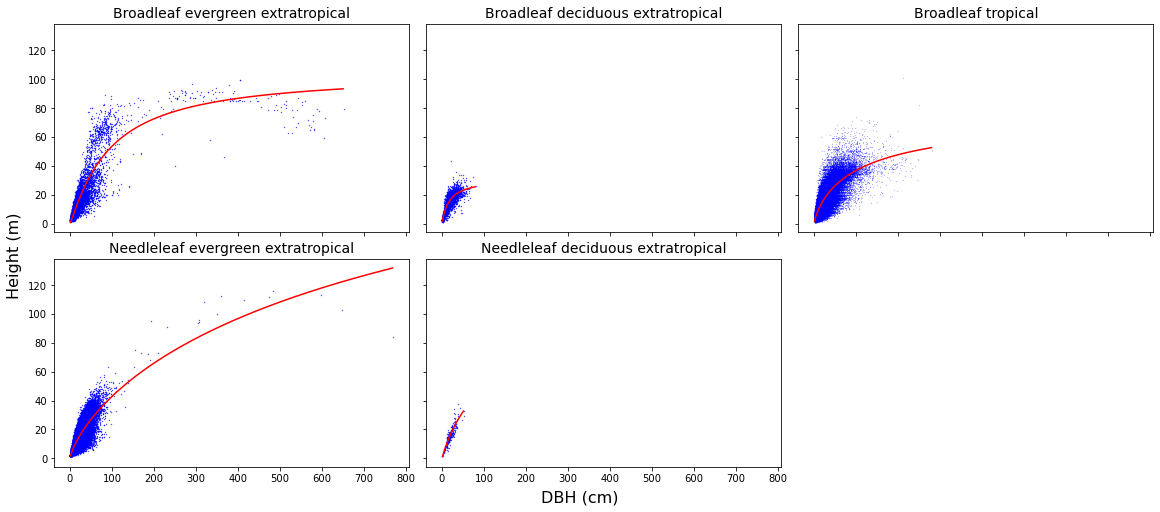

In [40]:
fig2, ((f2ax0, f2ax1, f2ax2),(f2ax3,f2ax4,f2ax5)) = plt.subplots(nrows=2,ncols=3,
                        figsize=(16,7), sharex=True, sharey=True, constrained_layout=True)

f2ax3.scatter(nleex.dbh, nleex.height, s=0.1, color='blue')
f2ax3.plot(dbh_nleex, nleex_curve, color='red')
f2ax3.set_title('Needleleaf evergreen extratropical', fontsize=14)

f2ax4.scatter(nldex.dbh, nldex.height, s=0.1, color='blue')
f2ax4.plot(dbh_nldex, nldex_curve, color='red')
f2ax4.set_title('Needleleaf deciduous extratropical', fontsize=14)

f2ax0.scatter(bleex.dbh, bleex.height, s=0.1, color='blue')
f2ax0.plot(dbh_bleex, bleex_curve, color='red')
f2ax0.set_title('Broadleaf evergreen extratropical', fontsize=14)

f2ax1.scatter(bldex.dbh, bldex.height, s=0.1, color='blue')
f2ax1.plot(dbh_bldex, bldex_curve, color='red')
f2ax1.set_title('Broadleaf deciduous extratropical', fontsize=14)

f2ax2.scatter(bltr.dbh, bltr.height, s=0.01, color='blue')
f2ax2.plot(dbh_bltr, bltr_curve, color='red')
f2ax2.set_title('Broadleaf tropical', fontsize=14)

f2ax5.axis('off')

fig2.supylabel('Height (m)', fontsize=16)
fig2.supxlabel('DBH (cm)', fontsize=16)
;

In [41]:
dbh = np.arange(1,350,1)
bldex_curve = [d2hmc(d, height_ps_bldex[0], height_ps_bldex[1], height_ps_bldex[2])  for  d  in dbh]
nldex_curve = [d2hmc(d, height_ps_nldex[0], height_ps_nldex[1], height_ps_nldex[2])  for  d  in dbh]
bleex_curve = [d2hmc(d, height_ps_bleex[0], height_ps_bleex[1], height_ps_bleex[2])  for  d  in dbh]
nleex_curve = [d2hmc(d, height_ps_nleex[0], height_ps_nleex[1], height_ps_nleex[2])  for  d  in dbh]
bltr_curve = [d2hmc(d, height_ps_bltr[0], height_ps_bltr[1], height_ps_bltr[2])  for  d  in dbh]


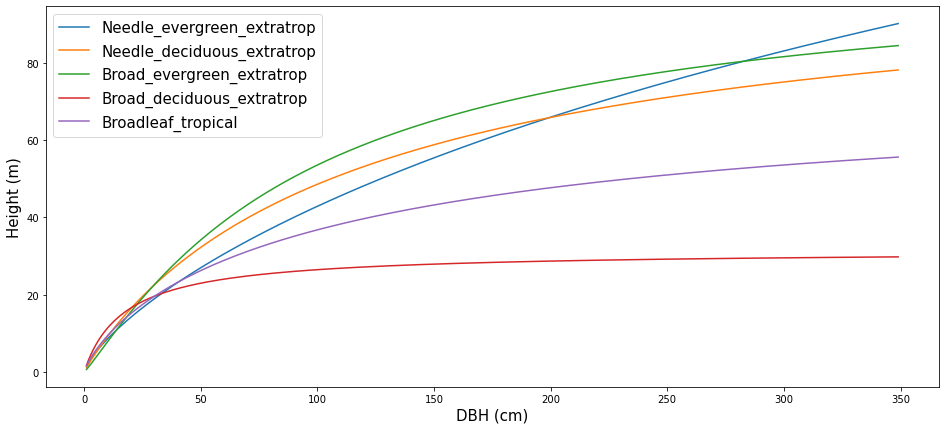

In [42]:
fig2, ((f2ax0)) = plt.subplots(nrows=1,ncols=1,
                        figsize=(16,7))

f2ax0.plot(dbh, nleex_curve, label =  'Needle_evergreen_extratrop')
f2ax0.plot(dbh, nldex_curve, label =  'Needle_deciduous_extratrop')
f2ax0.plot(dbh, bleex_curve, label =  'Broad_evergreen_extratrop')
f2ax0.plot(dbh, bldex_curve, label =  'Broad_deciduous_extratrop')
f2ax0.plot(dbh, bltr_curve, label =  'Broadleaf_tropical')
f2ax0.set_xlabel('DBH (cm)', fontsize=15)
f2ax0.set_ylabel('Height (m)',  fontsize=15)
f2ax0.legend(fontsize=15)

### Crown area allometry

In [43]:
def d2ca (d, p1) :
    ca = d ** p1
    return ca

[1.18011419]


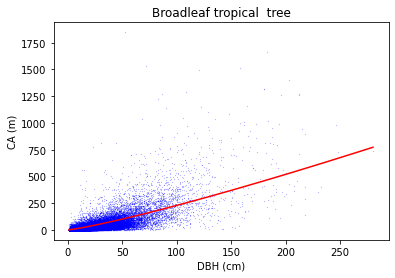

In [44]:
# Broadleaf tropical
bltr = df_tallo[df_tallo.PFT_tallo=='broadleaf_tropical']
# remove outliers
bltr = bltr[bltr['crown_radius_outlier'] == 'N']

bltr =  bltr.dropna(subset=['crown_area', 'dbh'])
ca_ps_bltr, ca_cov_bltr = curve_fit(f=d2ca, xdata=np.array(bltr['dbh']), ydata=np.array(bltr['crown_area']), p0=1.3)

bltr_curve = [d2ca(d, ca_ps_bltr[0])  for  d  in dbh_bltr]

plt.scatter(bltr.dbh, bltr.crown_area, s=0.01, color='blue')
plt.plot(dbh_bltr, bltr_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('CA (m)')
plt.title('Broadleaf tropical  tree')

print(ca_ps_bltr)

[0.91920499]


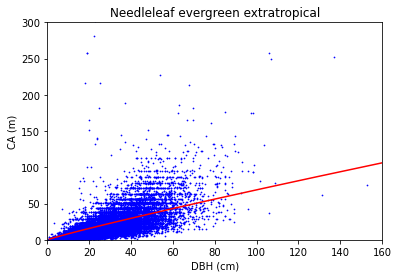

In [45]:
# Needleleaf  evergreen extra tropical
nleex = df_tallo[df_tallo.PFT_tallo=='needleleaf_evergreen_extratrop']
# remove outliers
nleex = nleex[nleex['crown_radius_outlier'] == 'N']

nleex =  nleex.dropna(subset=['crown_area', 'dbh'])
ca_ps_nleex, ca_cov_nleex = curve_fit(f=d2ca, xdata=np.array(nleex['dbh']), ydata=np.array(nleex['crown_area']), p0=1.3)

dbh_nleex = np.arange(1,nleex['dbh'].max(),1)
nleex_curve = [d2ca(d, ca_ps_nleex[0])  for  d  in dbh_nleex]

plt.scatter(nleex.dbh, nleex.crown_area, s=0.5, color='blue')
plt.plot(dbh_nleex, nleex_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('CA (m)')
plt.title('Needleleaf evergreen extratropical')
plt.xlim(0,160)
plt.ylim(0,300)

print(ca_ps_nleex)

[1.00732433]


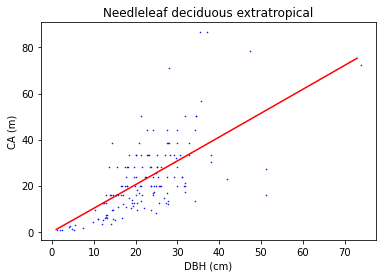

In [46]:
# Needleleaf  deciduous extra tropical
nldex = df_tallo[df_tallo.PFT_tallo =='needleleaf_deciduous_extratrop']
# remove outliers
nldex = nldex[nldex['crown_radius_outlier'] == 'N']

nldex =  nldex.dropna(subset=['crown_area', 'dbh'])
ca_ps_nldex, ca_cov_nldex = curve_fit(f=d2ca, xdata=np.array(nldex['dbh']), ydata=np.array(nldex['crown_area']), p0=1.3)

dbh_nldex = np.arange(1,nldex['dbh'].max(),1)
nldex_curve = [d2ca(d, ca_ps_nldex[0])  for  d  in dbh_nldex]

plt.scatter(nldex.dbh, nldex.crown_area, s=0.3, color='blue')
plt.plot(dbh_nldex, nldex_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('CA (m)')
plt.title('Needleleaf deciduous extratropical')

print(ca_ps_nldex)

[0.982688]


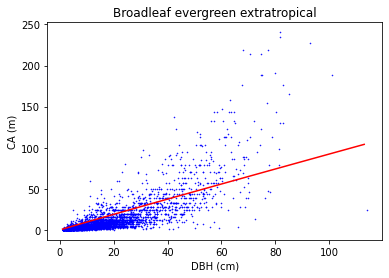

In [47]:
# broadleaf  evergreen extra tropical
bleex = df_tallo[df_tallo.PFT_tallo =='broadleaf_evergreen_extratrop']
# remove outliers
bleex = bleex[bleex['crown_radius_outlier'] == 'N']

bleex =  bleex.dropna(subset=['crown_area', 'dbh'])
ca_ps_bleex, ca_cov_bleex = curve_fit(f=d2ca, xdata=np.array(bleex['dbh']), ydata=np.array(bleex['crown_area']), p0=1.3)

dbh_bleex = np.arange(1,bleex['dbh'].max(),1)
bleex_curve = [d2ca(d, ca_ps_bleex[0])  for  d  in dbh_bleex]

plt.scatter(bleex.dbh, bleex.crown_area, s=0.3, color='blue')
plt.plot(dbh_bleex, bleex_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('CA (m)')
plt.title('Broadleaf evergreen extratropical')

print(ca_ps_bleex)

[1.08641676]


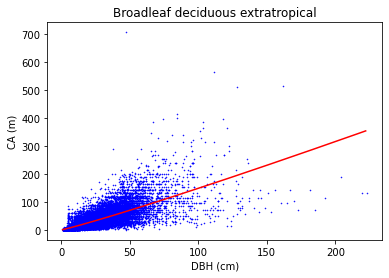

In [48]:
# broadleaf deciduous extra tropical
bldex = df_tallo[df_tallo.PFT_tallo =='broadleaf_deciduous_extratrop']

# remove outliers
bldex = bldex[bldex['crown_radius_outlier'] == 'N']

bldex =  bldex.dropna(subset=['crown_area', 'dbh'])
ca_ps_bldex, ca_cov_bldex = curve_fit(f=d2ca, xdata=np.array(bldex['dbh']), ydata=np.array(bldex['crown_area']), p0=1.3)

dbh_bldex = np.arange(1,bldex['dbh'].max(),1)
bldex_curve = [d2ca(d, ca_ps_bldex[0])  for  d  in dbh_bldex]

plt.scatter(bldex.dbh, bldex.crown_area, s=0.3, color='blue')
plt.plot(dbh_bldex, bldex_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('CA (m)')
plt.title('Broadleaf deciduous extratropical')

print(ca_ps_bldex)

''

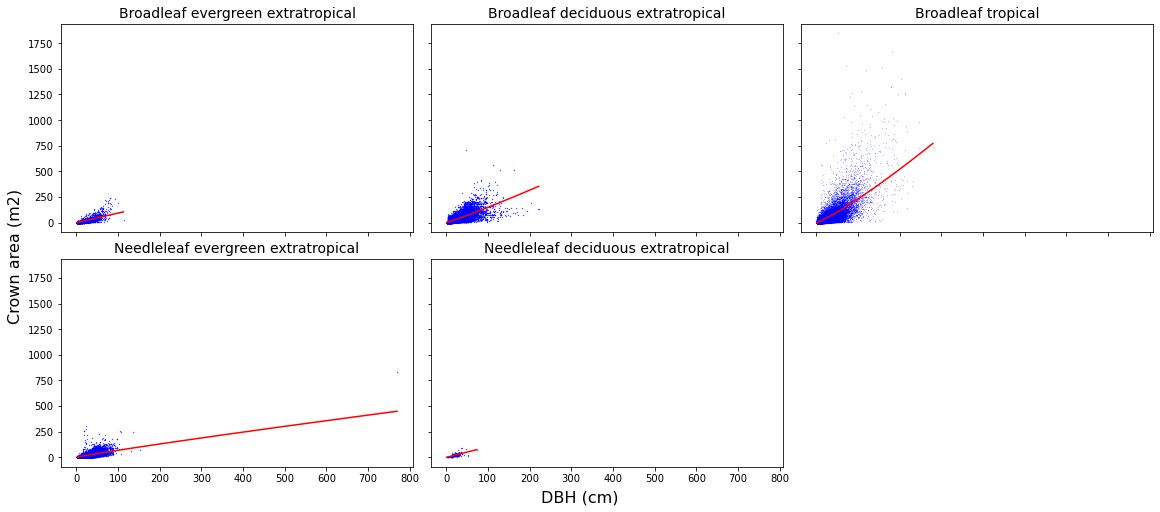

In [49]:
fig2, ((f2ax0, f2ax1, f2ax2),(f2ax3,f2ax4,f2ax5)) = plt.subplots(nrows=2,ncols=3,
                        figsize=(16,7), sharex=True, sharey=True, constrained_layout=True)

f2ax3.scatter(nleex.dbh, nleex.crown_area, s=0.1, color='blue')
f2ax3.plot(dbh_nleex, nleex_curve, color='red')
f2ax3.set_title('Needleleaf evergreen extratropical', fontsize=14)

f2ax4.scatter(nldex.dbh, nldex.crown_area, s=0.1, color='blue')
f2ax4.plot(dbh_nldex, nldex_curve, color='red')
f2ax4.set_title('Needleleaf deciduous extratropical', fontsize=14)

f2ax0.scatter(bleex.dbh, bleex.crown_area, s=0.1, color='blue')
f2ax0.plot(dbh_bleex, bleex_curve, color='red')
f2ax0.set_title('Broadleaf evergreen extratropical', fontsize=14)

f2ax1.scatter(bldex.dbh, bldex.crown_area, s=0.1, color='blue')
f2ax1.plot(dbh_bldex, bldex_curve, color='red')
f2ax1.set_title('Broadleaf deciduous extratropical', fontsize=14)

f2ax2.scatter(bltr.dbh, bltr.crown_area, s=0.01, color='blue')
f2ax2.plot(dbh_bltr, bltr_curve, color='red')
f2ax2.set_title('Broadleaf tropical', fontsize=14)

f2ax5.axis('off')

fig2.supylabel('Crown area (m2)', fontsize=16)
fig2.supxlabel('DBH (cm)', fontsize=16)
;

In [50]:
dbh = np.arange(1,350,1)
bldex_curve = [d2ca(d, ca_ps_bldex[0])  for  d  in dbh]
nldex_curve = [d2ca(d, ca_ps_nldex[0])  for  d  in dbh]
bleex_curve = [d2ca(d, ca_ps_bleex[0])  for  d  in dbh]
nleex_curve = [d2ca(d, ca_ps_nleex[0])  for  d  in dbh]
bltr_curve = [d2ca(d, ca_ps_bltr[0])  for  d  in dbh]


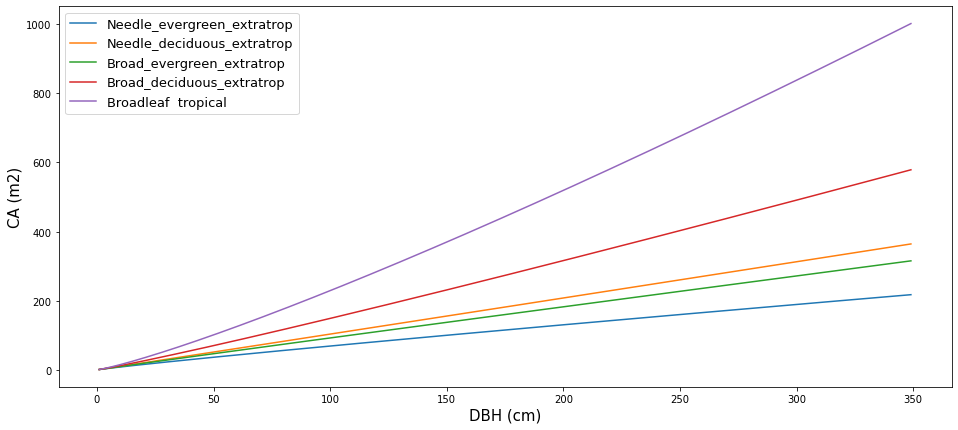

In [51]:
fig2, ((f2ax0)) = plt.subplots(nrows=1,ncols=1,
                        figsize=(16,7))

f2ax0.plot(dbh, nleex_curve, label =  'Needle_evergreen_extratrop')
f2ax0.plot(dbh, nldex_curve, label =  'Needle_deciduous_extratrop')
f2ax0.plot(dbh, bleex_curve, label =  'Broad_evergreen_extratrop')
f2ax0.plot(dbh, bldex_curve, label =  'Broad_deciduous_extratrop')
f2ax0.plot(dbh, bltr_curve, label =  'Broadleaf  tropical')
f2ax0.set_xlabel('DBH (cm)', fontsize=15)
f2ax0.set_ylabel('CA (m2)',  fontsize=15)
f2ax0.legend(fontsize=13)

## Aboveground biomass

We will only do  this for extra tropical since the tropical PFTs can use Chave 2014 parameters.
We will likely need to read in wood density estimates for many species that are lacking data in BAAD.

#### Load Wood Density Data 
These data are from TRY - compiled by Marcos Longo

In [52]:
df_wd = pd.read_csv('/pscratch/sd/j/jneedham/trait_data/wood_density_utf8.csv')

##### Make a new look up table with mean value per species

In [53]:
df_wd_mean = df_wd.groupby('ScientificName')['wood_dens'].mean().reset_index()
print(df_wd_mean.head(4))

            ScientificName  wood_dens
0  ARCTOSTAPHYLOS UVA-URSI   0.515767
1       Abarema adenophora   0.511729
2      Abarema barbouriana   0.418682
3    Abarema brachystachya   0.537852


In [54]:
# fill in bad data with wood density from TRY (from Marcos Longo)
print(df_baad['wd'].count())

1140


In [55]:
# Merge DataFrames based on matching values in 'x' and 's'
merged_df = df_baad.merge(df_wd_mean, left_on='species', right_on='ScientificName', how='left')
merged_df['wd'] = merged_df['wood_dens'].fillna(merged_df['wd'])
merged_df = merged_df.drop(columns=['wood_dens'])

In [56]:
print(merged_df['wd'].count())
df_baad = merged_df

5671


In [57]:
# Let's actually use mean wd by PFT  for fitting curves
pft_wd_means = df_baad.groupby('PFT_baad')['wd'].mean().reset_index()
print(pft_wd_means)

                         PFT_baad         wd
0   broadleaf_deciduous_extratrop   0.566452
1    broadleaf_deciduous_tropical  11.932701
2   broadleaf_evergreen_extratrop   0.754336
3    broadleaf_evergreen_tropical  57.430744
4  needleleaf_deciduous_extratrop   0.454845
5  needleleaf_evergreen_extratrop   0.442350


#### Needleleaf evergreen extra tropical 

[0.13640117 0.94490413]


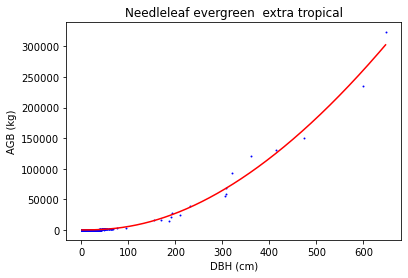

In [58]:
# Needleleaf evergreen extra tropical 
nleex = df_baad[df_baad.PFT_baad=='needleleaf_evergreen_extratrop']
nleex =  nleex.dropna(subset=['agb', 'dbh'])

initial_guess = [0.0673, 0.976]

def dh2bagw_nleex (d, p1, p2) :
    
    # set fixed parameters
    wd = pft_wd_means.loc[pft_wd_means['PFT_baad'] == 'needleleaf_evergreen_extratrop', 'wd'].values[0]
    h1 = height_ps_nleex[0]
    h2 = height_ps_nleex[1]
    h3 = height_ps_nleex[2]
    
    h = (h1 * d**h2) / (h3 + d*h2)
    
    agb = ( p1 * (wd * d**2 * h)**p2 ) / 2
    
    return agb


agb_ps_nleex, agb_cov_nleex = curve_fit(f=dh2bagw_nleex, xdata=np.array(nleex['dbh']), ydata=np.array(nleex['agb']),
                                           p0=initial_guess)

dbh_nleex = np.arange(1,nleex['dbh'].max(),1)

nleex_curve = [dh2bagw_nleex(d, agb_ps_nleex[0], agb_ps_nleex[1])  for  d  in dbh_nleex]

plt.scatter(nleex.dbh, nleex.agb, s=0.9, color='blue')
plt.plot(dbh_nleex, nleex_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('AGB (kg)')
plt.title('Needleleaf evergreen  extra tropical')

print(agb_ps_nleex)

#### Needleleaf deciduous extra tropical 

[0.03930566 1.08733502]


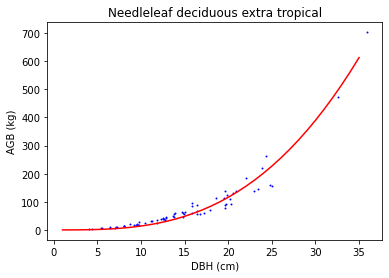

In [59]:
# Needleleaf deciduous extra tropical 
nldex = df_baad[df_baad.PFT_baad=='needleleaf_deciduous_extratrop']
nldex =  nldex.dropna(subset=['agb', 'dbh'])

initial_guess = [0.0673, 0.976]

def dh2bagw_nldex (d, p1, p2) :
    
    # set fixed parameters
    wd = pft_wd_means.loc[pft_wd_means['PFT_baad'] == 'needleleaf_deciduous_extratrop', 'wd'].values[0]
    h1 = height_ps_nldex[0]
    h2 = height_ps_nldex[1]
    h3 = height_ps_nldex[2]
    
    h = (h1 * d**h2) / (h3 + d*h2)
    
    agb = ( p1 * (wd * d**2 * h)**p2 ) / 2
    
    return agb


agb_ps_nldex, agb_cov_nldex = curve_fit(f=dh2bagw_nldex, xdata=np.array(nldex['dbh']), ydata=np.array(nldex['agb']),
                                           p0=initial_guess)

dbh_nldex = np.arange(1,nldex['dbh'].max(),1)

nldex_curve = [dh2bagw_nldex(d, agb_ps_nldex[0], agb_ps_nldex[1])  for  d  in dbh_nldex]

plt.scatter(nldex.dbh, nldex.agb, s=0.9, color='blue')
plt.plot(dbh_nldex, nldex_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('AGB (kg)')
plt.title('Needleleaf deciduous extra tropical')

print(agb_ps_nldex)

#### Broadleaf evergreen extra tropical 

[0.26536947 0.83213205]


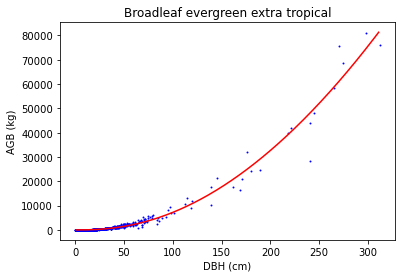

In [60]:
# Broadleaf evergreen extra tropical 
bleex = df_baad[df_baad.PFT_baad=='broadleaf_evergreen_extratrop']
bleex =  bleex.dropna(subset=['agb', 'dbh'])

initial_guess = [0.0673, 0.976]

def dh2bagw_bleex (d, p1, p2) :
    
    # set fixed parameters
    wd = pft_wd_means.loc[pft_wd_means['PFT_baad'] == 'broadleaf_evergreen_extratrop', 'wd'].values[0]
    h1 = height_ps_bleex[0]
    h2 = height_ps_bleex[1]
    h3 = height_ps_bleex[2]
    
    h = (h1 * d**h2) / (h3 + d*h2)
    
    agb = ( p1 * (wd * d**2 * h)**p2 ) / 2
    
    return agb


agb_ps_bleex, agb_cov_bleex = curve_fit(f=dh2bagw_bleex, xdata=np.array(bleex['dbh']), ydata=np.array(bleex['agb']),
                                           p0=initial_guess)

dbh_bleex = np.arange(1,bleex['dbh'].max(),1)

bleex_curve = [dh2bagw_bleex(d, agb_ps_bleex[0], agb_ps_bleex[1])  for  d  in dbh_bleex]

plt.scatter(bleex.dbh, bleex.agb, s=0.9, color='blue')
plt.plot(dbh_bleex, bleex_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('AGB (kg)')
plt.title('Broadleaf evergreen extra tropical')

print(agb_ps_bleex)

#### Broadleaf deciduous extra tropical

[0.07286975 1.03732112]


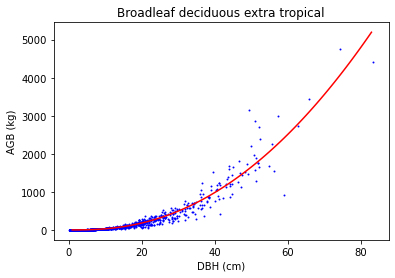

In [61]:
# Broadleaf deciduous extra tropical 
bldex = df_baad[df_baad.PFT_baad=='broadleaf_deciduous_extratrop']
bldex =  bldex.dropna(subset=['agb', 'dbh'])

initial_guess = [0.0673, 0.976]

def dh2bagw_bldex (d, p1, p2) :
    
    # set fixed parameters
    wd = pft_wd_means.loc[pft_wd_means['PFT_baad'] == 'broadleaf_deciduous_extratrop', 'wd'].values[0]
    h1 = height_ps_bldex[0]
    h2 = height_ps_bldex[1]
    h3 = height_ps_bldex[2]
    
    h = (h1 * d**h2) / (h3 + d*h2)
    
    agb = ( p1 * (wd * d**2 * h)**p2 ) / 2
    
    return agb


agb_ps_bldex, agb_cov_bldex = curve_fit(f=dh2bagw_bldex, xdata=np.array(bldex['dbh']), ydata=np.array(bldex['agb']),
                                           p0=initial_guess)

dbh_bldex = np.arange(1,bldex['dbh'].max(),1)

bldex_curve = [dh2bagw_bldex(d, agb_ps_bldex[0], agb_ps_bldex[1])  for  d  in dbh_bldex]

plt.scatter(bldex.dbh, bldex.agb, s=0.9, color='blue')
plt.plot(dbh_bldex, bldex_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('AGB (kg)')
plt.title('Broadleaf deciduous extra tropical')

print(agb_ps_bldex)